#Generating handwritten digits

##Import dependencies and specify input dimensions

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

## Build generator

In [ ]:
def build_generator(img_shape, z_dim): # takes in z as input and produces a 28 × 28 × 1 image

    model = Sequential()

    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU activation (prevent gradients from dying out during training)
    model.add(LeakyReLU(alpha=0.01)) 

    # Output layer with tanh activation
    model.add(Dense(28 * 28 * 1, activation='tanh')) # scale values to [–1, 1] (tahn tends to produce crisper images)

    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))

    return model

## Build discriminator

In [ ]:
def build_discriminator(img_shape): # takes in a 28 × 28 × 1 image and outputs a probability

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))

    # Fully connected layer
    model.add(Dense(128))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

## Build and compile the GAN

In [ ]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', #  Discriminator is trained as an independently compiled model
                      optimizer=Adam(), # Adam (adaptive moment estimation) is an advanced gradient descent-based optimizer
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam()) # difference between computed and actual probabilities

## Implement GAN training algorithm

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images (all 1s)
    real = np.ones((batch_size, 1))

    # Labels for fake images (all 0s)
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies for plotting
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

##Display generated images

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4): # outputs 4×4 grid of images synthesized by Generator per iteration

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Train the model

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 3ms/step
18000 [D loss: 0.471018, acc.: 78.52%] [G loss: 2.507617]
4/4 [==============================] - 0s 3ms/step
19000 [D loss: 0.435027, acc.: 82.42%] [G loss: 2.693958]
4/4 [==============================] - 0s 3ms/step
20000 [D loss: 0.431180, acc.: 79.69%] [G loss: 2.388153]
1/1 [==============================] - 0s 23ms/step


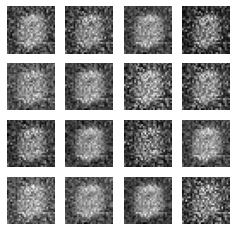

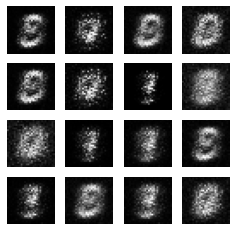

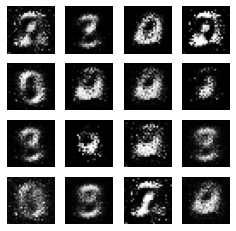

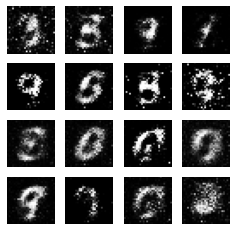

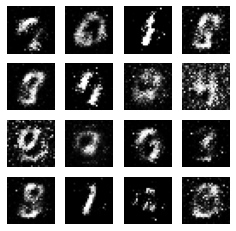

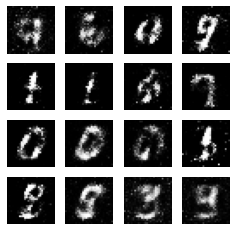

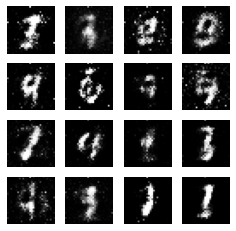

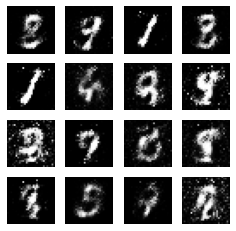

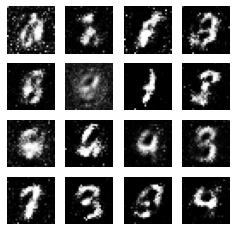

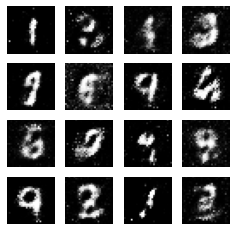

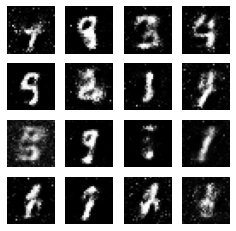

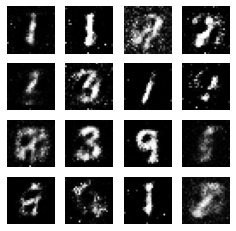

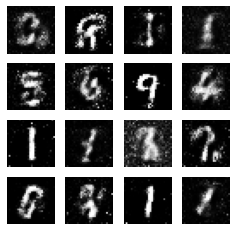

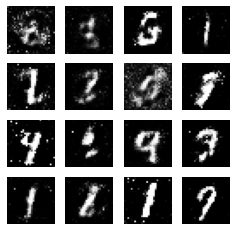

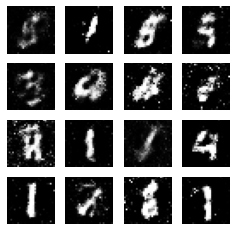

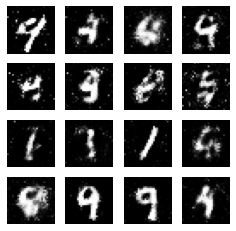

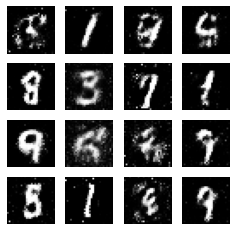

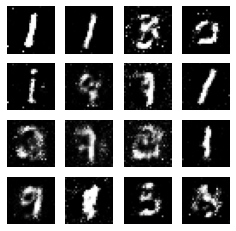

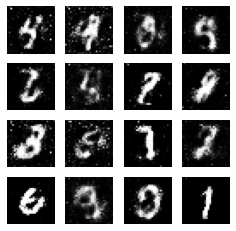

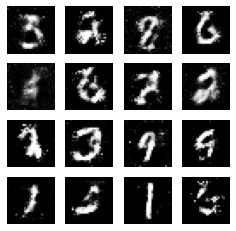

In [ ]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

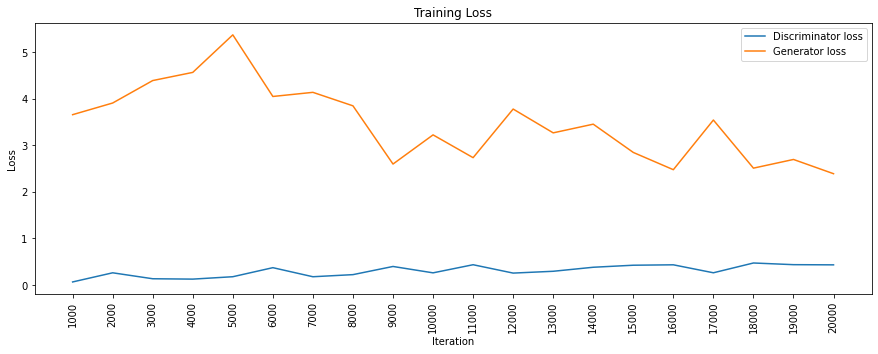

In [ ]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

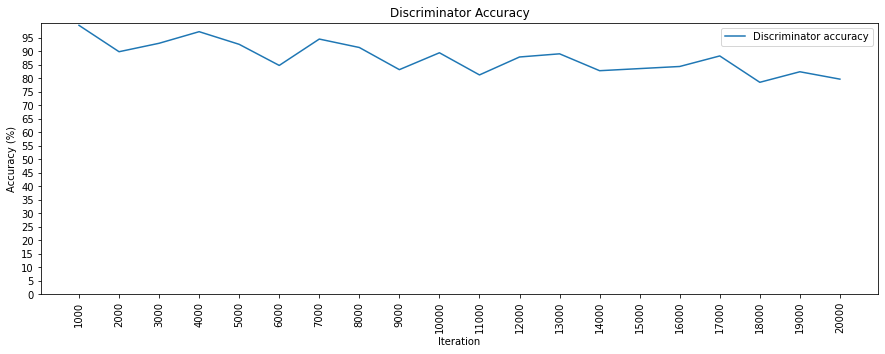

In [ ]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

#Generating handwritten digits with Deep Convolutional GANs (DCGANs)

####Import dependencies and load the dataset

In [2]:
%matplotlib inline

import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-pzxmnfz5
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-pzxmnfz5
  Resolved https://github.com/tensorflow/docs to commit 39227e7df9fe94d20a870de0ccef63304686d14f
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184468 sha256=229483fdbefa1f9a5b4118ba9cdee4e46300f7063ee99e605f5f0e0dd404b866
  Stored in directory: /tmp/pip-ephem-wheel-cache-7u6cx71k/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() # ignore test values

11490434/11490434 [==============================] - 2s 0us/step


In [5]:
# prepare the dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [6]:
# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Build DCGAN generator

In [7]:
def build_generator():
    
    model = tf.keras.Sequential()
    
    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))

    # Batch normalization decreases unwanted interdependence between parameters across layers (helps training speed and robustness)
    model.add(layers.BatchNormalization())

    # Leaky ReLU activation
    model.add(layers.LeakyReLU())

    # Reshape the vector of size 7 x 7 x 256 = 12544 into a 7 x 7 x 256 tensor
    model.add(layers.Reshape((7, 7, 256))) 
    
    # Assert that output shape is as expected
    assert model.output_shape == (None, 7, 7, 256)  # None is the batch size
    
    # Transposed convolution layer from 7x7x256 into 7x7x128 tensor given strides=1 (reverse the process: upsize the vector to an image)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))# bias vector ground truth unwanted

    # Assert output shape
    assert model.output_shape == (None, 7, 7, 128)

    # Batch normalization
    model.add(layers.BatchNormalization())

    # Leaky ReLU activation
    model.add(layers.LeakyReLU())

    # Transposed convolution layer from 7x7x128 to 14x14x64 tensor
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))

    # Assert output shape
    assert model.output_shape == (None, 14, 14, 64)

    # Batch normalization
    model.add(layers.BatchNormalization())

    # Leaky ReLU activation
    model.add(layers.LeakyReLU())

    # Output transposed convolution layer from 14x14x64 to 28x28x1 tensor with tanh activation
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    # Assert output shape
    assert model.output_shape == (None, 28, 28, 1)

    return model

###Test untrained generator (create image)

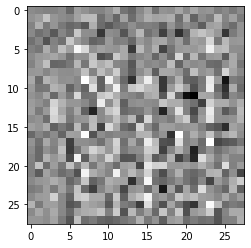

In [8]:
generator = build_generator()

# Sample random noise
noise = tf.random.normal([1, 100])

# Generate image from random noise
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Build DCGAN discriminator

In [9]:
def build_discriminator():

    model = tf.keras.Sequential()
    
    # Convolutional layer from 28x28x1 into 14x14x64 tensor (process image into a vector)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    
    # Leaky ReLU activation
    model.add(layers.LeakyReLU())

    # Dropout to prevent overfitting
    model.add(layers.Dropout(0.3))

    # Convolutional layer from 14x14x64 tensor into 7x7x128 tensor
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    
    # Leaky ReLU activation
    model.add(layers.LeakyReLU())

    # Dropout
    model.add(layers.Dropout(0.3))

    # Flatten the 7x7x128 tensor into a vector of size 3 × 3 × 128 = 1152
    model.add(layers.Flatten())

    # Output layer with sigmoid activation
    model.add(layers.Dense(1))

    return model

###Test untrained discriminator (classify image as real or fake)
The model will be trained to output positive values for real images, and negative values for fake images.

In [10]:
discriminator = build_discriminator()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0016344]], shape=(1, 1), dtype=float32)


## Define losses and optimizers



In [11]:
# Helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)# include softmax implicitly to produce output probabilities

### Discriminator loss

How well the discriminator is able to distinguish real images from fakes.

In [12]:
def discriminator_loss(real_output, fake_output):
    # Labels for real images: all 1s
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # Labels for fake images (all 0s)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

### Generator loss
How well it was able to trick the discriminator.

In [13]:
def generator_loss(fake_output):
    # Labels for fake 'real' images: all 1s
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
# Discriminator and generator optimizers awill train two different networks
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Create model checkpoints


In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer,
                                 generator=generator, discriminator=discriminator)

## Implement DCGAN training algorithm


In [16]:
noise_dim = 100
num_examples_to_generate = 16

# Reuse the random seed to visualize progress in animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
# tf.function causes the function to be 'compiled'
@tf.function
def train_step(images):
    # Generate noise batch
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # The generator receives random noise as input
      generated_images = generator(noise, training=True)
      # Get a random batch of real image drawn from the training set
      real_output = discriminator(images, training=True)
      # Generate a batch of fake images produced by the generator
      fake_output = discriminator(generated_images, training=True)

      # Calculate loss for each model
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    # Use gradients to update generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Generate GIF images going forward
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate image after final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

**Generate and save images**


In [19]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False) # Run layers in inference mode for batch norm efficiency

  # Set image grid
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # Output a grid of images
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

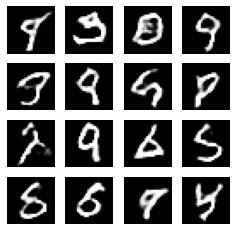

In [20]:
EPOCHS = 50

train(train_dataset, EPOCHS)

In [21]:
# Restore latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [22]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

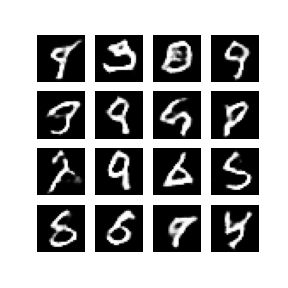

In [23]:
display_image(EPOCHS)

In [24]:
anim_file = 'dcgan.gif'
# Use imageio to create an animated gif using the images saved during training
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


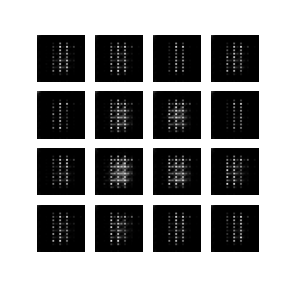

In [25]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### References
Codes from the book *GANs in Action* by Jakub Langr and Vladimir Bok, and from TensorFlow.org.